# CONET test
> compare conet with victree result

## Read simulated data

In [1]:
import scgenome.plotting as pl
import anndata
import pandas as pd

/Users/zemp/PycharmProjects/victree/venv/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/zemp/PycharmProjects/victree/venv/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/zemp/PycharmProjects/victree/venv/lib/python3.10/si

In [2]:
adata = anndata.read_h5ad("/Users/zemp/PycharmProjects/victree/datasets/simul_k5a7n300m2012e10-1000d10mt1-10-2500-50.h5ad")

/Users/zemp/PycharmProjects/victree/venv/lib/python3.10/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [3]:
adata.layers

Layers with keys: copy, state

{'fig': <Figure size 640x480 with 5 Axes>,
 'axes': array([[<Axes: >, <Axes: >],
        [<Axes: xlabel='chromosome'>, <Axes: >]], dtype=object),
 'adata': View of AnnData object with n_obs × n_vars = 300 × 2012
     obs: 'clone', 'baseline'
     var: 'chr', 'start', 'end'
     layers: 'copy', 'state',
 'im': <matplotlib.image.AxesImage at 0x28c513bb0>,
 'legend_info': {'ax_legend': <Axes: >,
  'legend': <matplotlib.legend.Legend at 0x28c5f8490>},
 'annotation_info': {}}

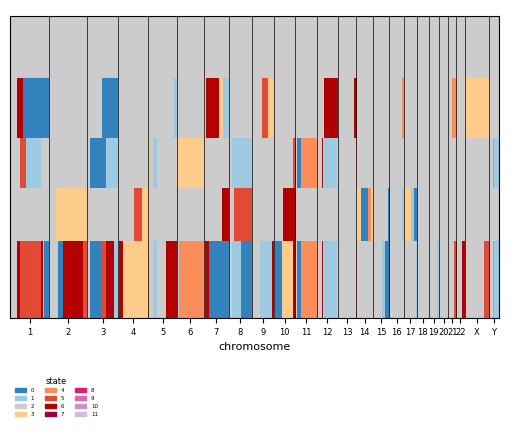

In [4]:
pl.plot_cell_cn_matrix_fig(adata, 'state', cell_order_fields=['clone'], max_cn=7)

## Candidate breakpoints

**ground truth candidate**

In [5]:
# create dataframe chr, start, end, c1, c2, ..., cN
adata.obs_names = pd.Series(['c' + str(i).zfill(4) for i in range(adata.n_obs)])
obs_df = adata.to_df(layer='copy').transpose()

In [6]:
# create dataframe chr, start, end, cn1, cn2, cnK
# to then transform into candidate_brkpt
clone_cn = adata.to_df(layer='state').drop_duplicates().transpose()
# possible breakpoints:
#   1. cn change
for c in clone_cn.columns:
    clone_cn[c] = (clone_cn[c].diff() != 0).astype(int)

clone_cn.head()

,c0000,c0001,c0003,c0004,c0007
0,1,1,1,1,1
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0


In [7]:
candidate_breakpoints_df = pd.concat([adata.var[['chr', 'start', 'end']], 
                                      clone_cn.prod(axis=1).rename('candidate_brkp')], axis=1)
conet_df = pd.concat([candidate_breakpoints_df, obs_df], axis=1)
conet_df.head()

,chr,start,end,candidate_brkp,c0000,c0001,c0002,c0003,c0004,c0005,...,c0290,c0291,c0292,c0293,c0294,c0295,c0296,c0297,c0298,c0299
0,1,0,1549868,1,1.804362,1.978042,1.997247,2.076500,1.728144,1.908139,...,1.997477,1.735741,1.932484,2.044921,2.105437,2.225175,2.117285,1.873872,2.126660,1.982203
1,1,1549868,3099736,0,1.924912,1.920113,2.073836,1.859172,1.902410,1.816983,...,1.792584,1.893874,1.996491,2.277385,2.070604,1.969832,2.119550,2.109384,2.247047,2.264290
2,1,3099736,4649604,0,1.608191,1.750273,1.949237,2.052145,1.990869,1.640945,...,1.915367,1.593306,2.121506,2.319390,2.206440,2.216484,1.891138,1.987253,2.015648,2.043902
3,1,4649604,6199472,0,1.954437,1.922123,1.827253,1.763524,1.806883,1.667633,...,1.715031,1.733487,1.795792,2.224655,1.750854,1.907336,1.940248,2.092002,1.884669,2.127871
4,1,6199472,7749340,0,2.169822,2.034965,1.841820,2.319825,2.020610,2.029629,...,1.920180,1.922212,1.864454,2.280417,1.883932,1.891093,2.008379,1.672374,1.922325,1.846295


In [8]:
chr_codes = {str(i): i for i in range(1, 23)}
chr_codes['X'] = 23
chr_codes['Y'] = 24
conet_df['chr'] = conet_df['chr'].map(chr_codes)
conet_df['width'] = conet_df['end'] - conet_df['start']

In [9]:
(obs_df.diff().abs() > 3).sum(axis=1) > (.8 * obs_df.shape[1])

0       False
1       False
2       False
3       False
4       False
        ...  
2007    False
2008    False
2009    False
2010    False
2011    False
Length: 2012, dtype: bool

In [10]:
#   2. beginning and end of chromosomes
beg_end_chr_loc = (conet_df['chr'].shift(1) != conet_df['chr']) | (conet_df['chr'].shift(-1) != conet_df['chr'])
conet_df.loc[beg_end_chr_loc, 'candidate_brkp'] = 1
print(f"beg-end chr new candidates: {beg_end_chr_loc.sum()}")

beg-end chr new candidates: 48


In [11]:
#   3. high corr counts abs diff evidence (> 80% of cells have diff > 3)
high_diff_mask = (obs_df.diff().abs() > 3).sum(axis=1) > (.3 * obs_df.shape[1])
conet_df.loc[high_diff_mask, 'candidate_brkp'] = 1
print(f"high count diff new candidates: {high_diff_mask.sum()}")

high count diff new candidates: 4


In [12]:
#   4. locus to the right of previously computed candidate
shifted_cand_brkp_mask = conet_df['candidate_brkp'].shift(1, fill_value=0) == 1
conet_df.loc[shifted_cand_brkp_mask, 'candidate_brkp'] = 1
print(f"shift to right new candidates: {shifted_cand_brkp_mask.sum()}")

shift to right new candidates: 50


In [13]:
# save file csv
conet_df.to_csv("/Users/zemp/phd/msk/conet-exp/corr_counts.csv", index=False)

**HMMcopy pre-processing**

## Run CONET

In [14]:
bin_dir = "/Users/zemp/phd/scilife/cpt_experiments/CONET/CONET"
from conet import CorrectedCounts, DataConverter

cc = CorrectedCounts(conet_df)
DataConverter(event_length_normalizer=3095677412).create_CoNET_input_files(bin_dir, corrected_counts=cc)

## Load VICTREE output

## Compare with ARI score